# Introduction

LLRF system feedback loops have optimization routine, to determine optimal operating point, using a ‘network analyzer’ probe technique for feedback frequency response analysis, the well known [Bode plot](https://en.wikipedia.org/wiki/Bode_plot). This is done by injecting a known excitation tone to the feedback controller through the setpoint, and measure the response amplitude and phase. If one can scan excitation tone over the bandwidth of interest, the Bode plot can be obtained. The same process is applied to both amplitude and phase loops. In this lab you have the choice of either amplitude or phase loop characterization.

## Firmware details

The excitation tone is generated by an additional DDS unit in the firmware, through the usual registers of phase step high, low and modulo, plus its amplitude control register. 

The excitation tone would only be added to the normal loop setpoint if the network analyzer is enabled, through register `ntw_amp_enable`.

Firmware level block diagram for amplitude loop:

![ntw_analyzer.png](uspas_llrf-ntw.png)

The same is for phase loop, except the register names has `phs` instead of `amp`.

## Steps

1. Confirm system is in normal closed-loop operation state, with certain conditions such as RF power level.
2. A known excitation signal (a single frequency tone, or a chirp) is generated and added on the setpoint of either amplitude or phase loop. This signal is synchronous to waveform triggering, so the measured result would be consistent across waveforms.
3. Record waveform of interest, for example, cavity cell amplitude or phase waveform.
4. If using a single frequency tone excitation, scan the tone frequency across analyze bandwidth of 10 Hz to 100 kHz, and record waveform accordingly.
5. Compute frequency response (amplitude and phase) between the excitation signal and measured waveform, derive bode plot.
6. Explore different gain settings, find amplitude margin and phase margin for stability.


## EPICS PVs:

Note: all raw registers like `reg_*` have separate write and read-back PVs.

To write a raw register such as `USPAS:LLRF:reg_amp_loop_enable`:
```bash
caput USPAS:LLRF:reg_amp_loop_enable 0
```
To read it back, read the PV with `_RBV` as suffix.
```bash
caget USPAS:LLRF:reg_amp_loop_enable_RBV
```


#### Waveform:
* `USPAS:LLRF:CavCel:AWF`
: Holds cavity cell amplitude data, in counts
* `USPAS:LLRF:CavCel:PWF`
: Holds cavity cell phase data, in degrees
* `USPAS:LLRF:CavCel:TWF`
: Holds cavity cell time data, in microsecond
* `USPAS:LLRF:ACQ_SAMP_PERIOD`
: Waveform sampling period
* `USPAS:LLRF:ACQ_DECIM`
: Waveform decimation value


#### Amplitude loop:
* `USPAS:LLRF:Loop:AmpSetp`
: Holds amplitude loop setpoint value, calibrated with waveform
* `USPAS:LLRF:reg_amp_setpoint`
: Holds amplitude loop setpoint value, raw
* `USPAS:LLRF:reg_amp_loop_enable`
: Enables amplitude loop
* `USPAS:LLRF:reg_amp_loop_reset`
: Resets amplitude loop
* `USPAS:LLRF:reg_Kp_amp`
: Amplitude loop proportional gain
* `USPAS:LLRF:reg_Ki_amp`
: Amplitude loop integral gain


#### Phase loop:
* `USPAS:LLRF:Loop:PhsSetp`
: Holds phase loop setpoint value, calibrated with waveform
* `USPAS:LLRF:reg_phs_setpoint`
: Holds phase loop setpoint value, raw
* `USPAS:LLRF:reg_phs_loop_enable`
: Enables phase loop
* `USPAS:LLRF:reg_phs_loop_reset`
: Resets phase loop
* `USPAS:LLRF:reg_Kp_phs`
: Phase loop proportional gain
* `USPAS:LLRF:reg_Ki_phs`
: Phase loop integral gain


#### Network analyzer:
* `USPAS:LLRF:reg_ntw_amp_enable`
: Enables amplitude loop network analzyer feature
* `USPAS:LLRF:reg_ntw_phs_enable`
: Enables phase loop network analzyer feature
* `USPAS:LLRF:reg_ntw_lo_amp`
: Network analzyer amplitude value
* `USPAS:LLRF:reg_ntw_phase_step_h`
: Network analyze major resolution value, like DDS minor resolution
* `USPAS:LLRF:reg_ntw_phase_step_l`
: Network analyze minor resolution value, like DDS major resolution
* `USPAS:LLRF:reg_ntw_modulo`
: Network analyze modulo value, like DDS modulo



## Hardware setup

![uspas_llrf-ntw_an.png](uspas_llrf-ntw_an.png)

Connect the system as shown in the diagram, so we have both direct loop back on `ADC1` and with 20 MHz crystal in the system on `ADC5`.
The firmware has identical `DAC Q1` and `DAC Q2` output, as we previously measured on the DAC characterization lab.

## Firmware and software setup
* Configure FPGA chassis using the provided `marble_zest_top_uspas.bit`;
* Start EPICS IOC on the connected laptop computer;
* Run Phoebus GUI on the connected laptop computer;
* `Note: Phase shift/error caused by cic decimation in the FPGA waveform capture module is 14.442 radians. Measured by sweeping the decimation factor from 1 to 127 at a given frequency.`

# Exercises

## Run EPICS Phoebus interface

## Close both amplitude and phase loops

##  Enable either amplitude or phase network analyzer feature and run frequency sweep routine

## Capture cavity cell amplitude/phase data along with the time data. Compensate for CIC phase error.

## Calculate closed loop transfer function

## Calculate open loop transfer function based on closed loop transfer function

## Plot amplitude and phase bode plots

## Calculate gain and phase margins

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import numpy.fft
import ntw_analyzer
from scipy import signal
from numpy import savetxt, loadtxt
from scipy import signal
from scipy.signal.windows import flattop

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

In [2]:
from epics import PV
import os
os.environ['EPICS_CA_ADDR_LIST'] = 'localhost'
os.environ['EPICS_CA_AUTO_ADDR_LIST'] = 'NO'

prefix = 'USPAS:LLRF:'
pvs = {
    'cav_cel_amp_wfm': PV(prefix + 'CavCel:AWF'),
    'cav_cel_phs_wfm': PV(prefix + 'CavCel:PWF'),
    'cav_cel_time_wf': PV(prefix + 'CavCel:TWF'),

    'amp_loop_setp': PV(prefix + 'Loop:AmpSetp'),
    'amp_loop_setp_eslo': PV(prefix + 'Loop:AmpSetp.ESLO'),
    'amp_loop_kp': PV(prefix + 'reg_Kp_amp'),
    'amp_loop_ki': PV(prefix + 'reg_Ki_amp'),
    'phs_loop_setp': PV(prefix + 'Loop:PhsSetp'),
    'phs_loop_kp': PV(prefix + 'reg_Kp_phs'),
    'phs_loop_ki': PV(prefix + 'reg_Ki_phs'),
    'amp_loop_enable': PV(prefix + 'reg_amp_loop_enable'),
    'phs_loop_enable': PV(prefix + 'reg_phs_loop_enable'),
    
    'ntw_amp_enable': PV(prefix + 'reg_ntw_amp_enable'),
    'ntw_phs_enable': PV(prefix + 'reg_ntw_phs_enable'),
    'ntw_reset': PV(prefix + 'reg_ntw_reset'),
    'ntw_lo_amp': PV(prefix + 'reg_ntw_lo_amp'),
    'ntw_phase_step_h': PV(prefix + 'reg_ntw_phase_step_h'),
    'ntw_phase_step_l': PV(prefix + 'reg_ntw_phase_step_l'),
    'ntw_modulo': PV(prefix + 'reg_ntw_modulo'),

    'amp_loop_reset': PV(prefix + 'reg_amp_loop_reset'),
    'phs_loop_reset': PV(prefix + 'reg_phs_loop_reset'),
    'samp_period': PV(prefix + 'ACQ_SAMP_PERIOD'),
    'wave_decim': PV(prefix + 'ACQ_DECIM'),
    'wave_samp_per': PV(prefix + 'reg_wave_samp_per')
}

In [30]:
import sys
sys.path.append('..')
sys.path.append('../Day2/dds')
from dds import reg2freq, calc_dds

In [12]:
f_tone = 100  # Hz
fs = 115e6
den = 23
num = f_tone * den / fs
ph, pl, modulo = calc_dds(num, den, dwh=32, dwl=12)
print(ph, pl, modulo)
fdds = reg2freq(ph, pl, modulo, fs, dwh=32, dwl=12)
print(f'New DDS Freq: {fdds:.2f} Hz')

3734 3087 2
major resolution:  0.027 Hz
minor resolution:  0.000 Hz
modulo resolution: 0.000 Hz
New DDS Freq: 100.00 Hz


In [13]:
pvs['ntw_lo_amp'].value = 150
pvs['ntw_modulo'].value = modulo
pvs['ntw_phase_step_l'].value = pl
pvs['ntw_phase_step_h'].value = ph

Turn on amplitude ntw excitation

In [106]:
pvs['ntw_amp_enable'].value = 1

In [42]:
pvs['ntw_amp_enable'].value = 0
import numpy as np 
from random import randint
from time import sleep
np.savetxt('awf.txt', pvs['cav_cel_amp_wfm'].value)
np.savetxt('twf.txt', pvs['cav_cel_time_wf'].value)

class Parameters():
    def __init__(self, kp, ki, rms):
        self.kp = kp
        self.ki = ki
        self.rms = rms
        
    def __lt__(self, other):
        return self.rms < other.rms
    
    def __gt__(self, other):
        return self.rms > other.rms
    
    def __eq__(self, other):
        return self.rms == other.rms
    
    def __str__(self):
        return f'kp {self.kp}, ki {self.ki}, rms {self.rms}'

def find_rms(kp, ki):
    pvs["amp_loop_kp"].put(kp)
    pvs["amp_loop_ki"].put(ki)
    amp_data = pvs["cav_cel_amp_wfm"].get()
    ades = pvs["amp_loop_setp"].get()
    amp_errors = amp_data - ades
    # print(max(amp_errors))
    return np.sqrt(np.mean(np.square(amp_errors)))

rms_obj_list = []
for _ in range(5):
    kp = randint(1,10000)
    ki = randint(1,10000)
    print(kp, ki)
    rms_obj_list.append(Parameters(kp, ki, find_rms(kp, ki)))
    sleep(2)
for param_obj in rms_obj_list:
    print(str(param_obj))

9626 4964
3069 4646
6572 6732
7243 2722
4047 5275
kp 9626, ki 4964, rms 0.5596726633299316
kp 3069, ki 4646, rms 0.5638393687241031
kp 6572, ki 6732, rms 0.5697242490098474
kp 7243, ki 2722, rms 0.561418122609769
kp 4047, ki 5275, rms 0.5695211199769009


![amp on](ntw_amp_on.png)

In [31]:
def drive_ntw(f_tone=100, den=23, fs=115e6):
    num = f_tone * den / fs
    ph, pl, modulo = calc_dds(num, den, dwh=32, dwl=12)
    pvs['ntw_lo_amp'].value = 150
    pvs['ntw_modulo'].value = modulo
    pvs['ntw_phase_step_l'].value = pl
    pvs['ntw_phase_step_h'].value = ph

In [254]:
awf = pvs['cav_cel_amp_wfm'].get()
drive_ntw(f_tone=100000)
awf = pvs['cav_cel_amp_wfm'].get()
twf = pvs['cav_cel_time_wf'].get()
print(twf[-1])
print(1/(twf[1]*8192*1e-6))
f_harmonic=4.8059178149606305

208051.39999997
4.8059178149606305


In [255]:
awfs = []
import time
for f in [f_harmonic * idx for idx in range(2,200)]:
#for f in range(10, 1000, 10):
    print(f'Driving f_tone: {f} Hz')
    drive_ntw(f_tone=f)
    time.sleep(2)
    awfs.append((f,pvs['cav_cel_amp_wfm'].get()))

Driving f_tone: 9.611835629921261 Hz
Driving f_tone: 14.417753444881892 Hz
Driving f_tone: 19.223671259842522 Hz
Driving f_tone: 24.02958907480315 Hz
Driving f_tone: 28.835506889763785 Hz
Driving f_tone: 33.641424704724415 Hz
Driving f_tone: 38.447342519685044 Hz
Driving f_tone: 43.253260334645674 Hz
Driving f_tone: 48.0591781496063 Hz
Driving f_tone: 52.86509596456693 Hz
Driving f_tone: 57.67101377952757 Hz
Driving f_tone: 62.4769315944882 Hz
Driving f_tone: 67.28284940944883 Hz
Driving f_tone: 72.08876722440945 Hz
Driving f_tone: 76.89468503937009 Hz
Driving f_tone: 81.70060285433073 Hz
Driving f_tone: 86.50652066929135 Hz
Driving f_tone: 91.31243848425198 Hz
Driving f_tone: 96.1183562992126 Hz
Driving f_tone: 100.92427411417324 Hz
Driving f_tone: 105.73019192913387 Hz
Driving f_tone: 110.5361097440945 Hz
Driving f_tone: 115.34202755905514 Hz
Driving f_tone: 120.14794537401576 Hz
Driving f_tone: 124.9538631889764 Hz
Driving f_tone: 129.75978100393704 Hz
Driving f_tone: 134.5656988188

In [256]:
arr = np.array(awfs)
np.save('amp100.npy', arr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (198, 2) + inhomogeneous part.

In [68]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt

3277
990


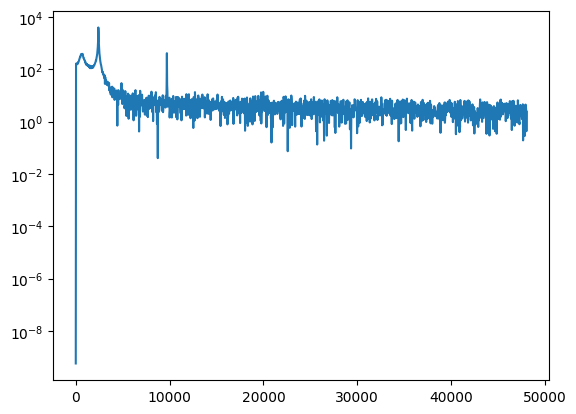

In [241]:
wf = awfs[-1][1]
print(len(wf))
print(awfs[-1][0])
wf = wf - np.average(wf)
#plt.plot(wf)
fft = np.fft.rfft(wf)
freqs = np.fft.rfftfreq(len(wf), 10.4e-6).tolist()
plt.semilogy(freqs, np.abs(fft))

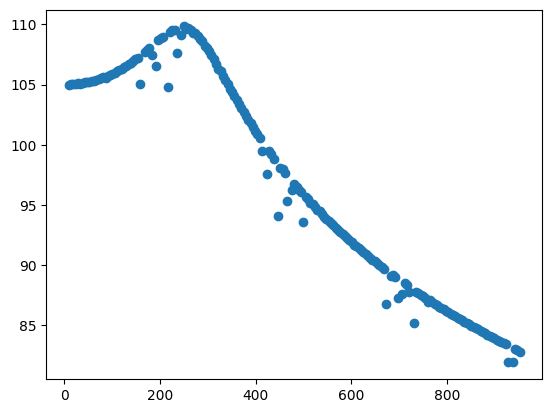

In [257]:
responses = {}
for f, wf in awfs:
    #f, p = periodogram(wf, fs=115e6)
    #wf = wf[500:]
    wf = wf-np.average(wf)
    #per = 1/f # period of sampled waveform
    #dt = 25.4e-6 # sample period
    #nmax = dt*len(wf)/per # total time of sample window divided by period (i.e. periods in sample window)
    ##nmax = dt*int(len(wf)/per) # The closest we can get to an integral number of periods in the sample window
    #x = int(nmax*per/dt)
    #wf = wf[:x]
    fft = np.fft.rfft(wf)
    freqs = np.fft.rfftfreq(len(wf), 25.4e-6).tolist()
    fft_abs = np.abs(fft).tolist()
    max_freq = max(fft_abs)
    max_idx = fft_abs.index(max_freq)
    responses[freqs[max_idx]]= fft[max_idx]
    
print()

magnitudes = {}
phases = {}
for freq, response in responses.items():
    magnitudes[freq] = np.abs(response)
    #print(np.angle(response))
    phases[freq] = np.angle(response)
plt.scatter(list(magnitudes.keys()), 20*np.log10(list(magnitudes.values())))
#plt.plot(list(magnitudes.keys()), list(magnitudes.values()))


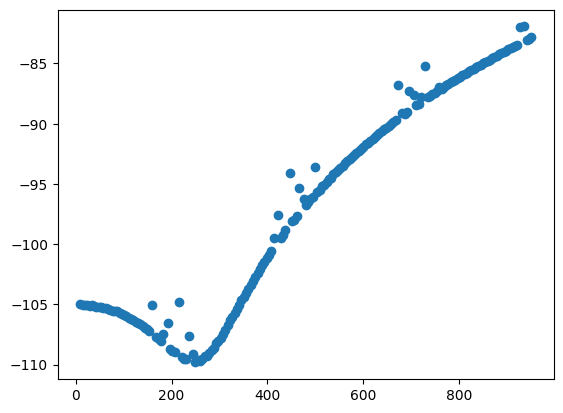

In [258]:
def open_func(freq):
    return 1/(1-responses[freq])

open_vals = {freq: open_func(freq) for freq in responses.keys()}

open_magnitudes = {}
open_phases = {}
for freq, open_val in open_vals.items():
    open_magnitudes[freq] = np.abs(open_val)
    #print(np.angle(response))
    open_phases[freq] = np.angle(open_val)
plt.scatter(list(open_magnitudes.keys()), 20*np.log10(list(open_magnitudes.values())))


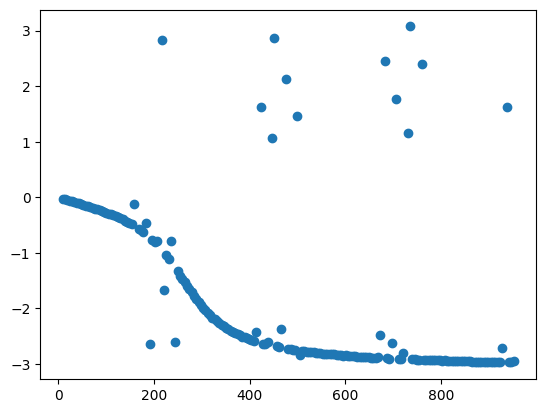

In [261]:
phase_list = list(phases.values())
#phase_list = np.unwrap(phase_list)
plt.scatter(list(phases.keys()), phase_list)

{29.34203422454872: (-10412.240667054028-39247.825522162275j), 117.36813689819488: (29967.341898201907-67611.53135442192j), 205.39423957184104: (102189.65785460116-37731.98326229496j), 322.7623764700359: (-56096.71068120255+23381.096917958566j), 410.7884791436821: (-37550.42312022433-19308.881118055964j), 498.81458181732825: (225.24204235045337-19461.327486444243j), 616.1827187155232: (-12949.766086936404+5161.360332728891j), 704.2088213891693: (-6781.30746244346-7827.722585571437j), 821.5769582873642: (-3028.586596000915+5190.495622721948j), 909.6030609610103: (-6134.956081554938-1378.0059940187177j), 997.6291636346565: (-317.31716403750994-3740.2808308363237j), 1114.9973005328513: (-3581.9534319312443+1460.4539758686692j), 1203.0234032064975: (-1998.5411533096358-2422.7357819527488j), 1320.3915401046925: (-1263.0724710550965+1926.2066568009425j), 1408.4176427783386: (-1707.9951760030167-421.04194335983385j), 1613.8118823501795: (-313.11292818305304-1328.491223720582j), 1701.837985023

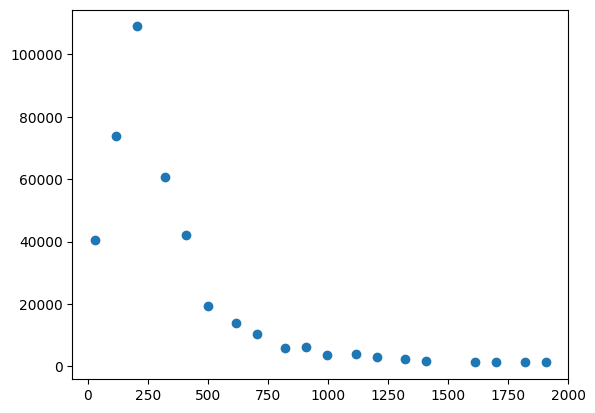

In [182]:
print(responses)
magnitudes = {}
phases = {}
for freq, response in responses.items():
    magnitudes[freq] = np.abs(response)
    phases[freq] = np.angle(response)
print(magnitudes)
plt.scatter(list(magnitudes.keys()), list(magnitudes.values()))

In [148]:
points = []
for idx, response in enumerate(responses):
    max_response = max(response[1])
    max_idx = response[1].index(max_response)
    max_freq = response[0][max_idx]
    points.append((max_freq, max_response))

TypeError: 'numpy.complex128' object is not iterable

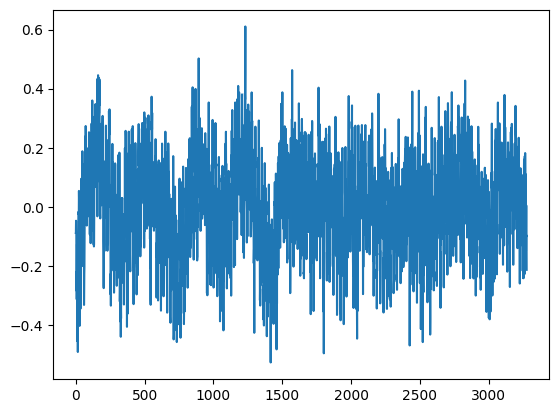

In [155]:
wf = awfs[-1][1]
wf = wf - np.average(wf)
plt.plot(wf)


In [152]:
print(len(awfs))
wf = awfs[:-1][1]
wf = wf - np.average(wf)
per = 1/500 # period of sampled waveform
dt = 10.4e-6 # sample period
nmax = dt*len(wf)/per # total time of sample window divided by period (i.e. periods in sample window)
#nmax = dt*int(len(wf)/per) # The closest we can get to an integral number of periods in the sample window
x = int(nmax*per/dt)
print(f"x = {x}")
wf = wf[:x]
print(f"wf[:3] = {wf[:3]}")
print(f"nmax = {nmax}")
plt.plot(wf)
fft = np.fft.rfft(wf)
freqs = np.fft.rfftfreq(len(wf), 10.4e-6).tolist()
mags = np.abs(fft).tolist()
max_mag = max(mags)
max_idx = mags.index(max_mag)
print(freqs[max_idx])
#plt.semilogy(freqs,mags)
#plt.xlim(0,1000)

10


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.